In [1]:
import os
import difflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches as mpatches

import sys
sys.path.append('../../')
from rllte.evaluation.visualization import _annotate_and_decorate_axis, plot_interval_estimates
from rllte.evaluation import Performance
from utils import smooth

# q7 curves

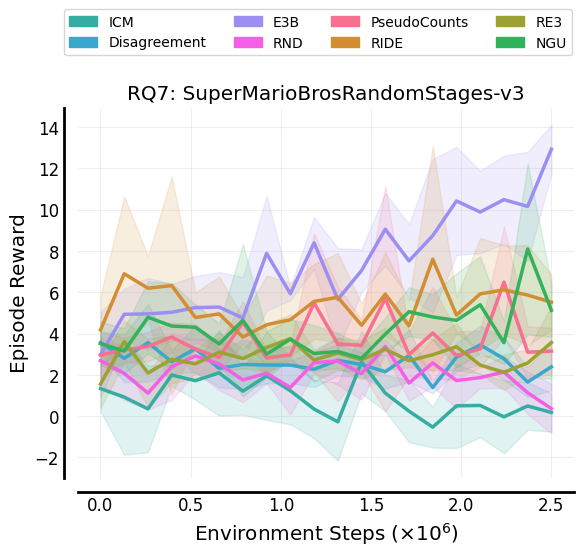

In [3]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU']
colors = sns.husl_palette(len(algos), h=.5)
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(algos)]

root = "/Users/yuanmingqi/Downloads/nips2024_data/q7_new"
num_points = 20
all_data = {algo: [] for algo in algos}
for algo in algos:
    for dir in os.listdir(root):
        if algo.lower() in dir:
            file = f"{root}/{dir}/"
            file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
            data = pd.read_csv(file)['episode_reward']
            data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
            # data = smooth(data, 0.95)
            all_data[algo].append(data)

    all_data[algo] = np.array(all_data[algo])

fig, ax = plt.subplots()

x = np.linspace(0, 2.5, num_points)
for algo, color in zip(algos, colors):
    mean, std = np.mean(all_data[algo], axis=0), np.std(all_data[algo], axis=0)
    ax.plot(x, mean, linewidth=2.5, c=color, label=algo)
    ax.fill_between(x, mean+std, mean-std, alpha=0.15, color=color)

ax.set_title('RQ7: SuperMarioBrosRandomStages-v3', fontsize="x-large")
ax = _annotate_and_decorate_axis(ax, 
                                 ticklabelsize="large",
                                 xlabel=r"Environment Steps ($\times 10^6$)", 
                                 ylabel="Episode Reward",
                                 xticklabels=np.linspace(0, 1, num_points),
                                 )

fig.legend(fake_patches, algos, loc='upper center', 
    fancybox=True, ncol=4,
    # fontsize='x-large',
    bbox_to_anchor=(0.5, 1.1))
fig.savefig('figure_rq7_curves.pdf', bbox_inches='tight', dpi=300)

 ICM (5, 200)
 Disagreement (5, 200)
 E3B (5, 200)
 RND (5, 200)
 PseudoCounts (5, 200)
 RIDE (5, 200)
 RE3 (5, 200)
 NGU (5, 200)


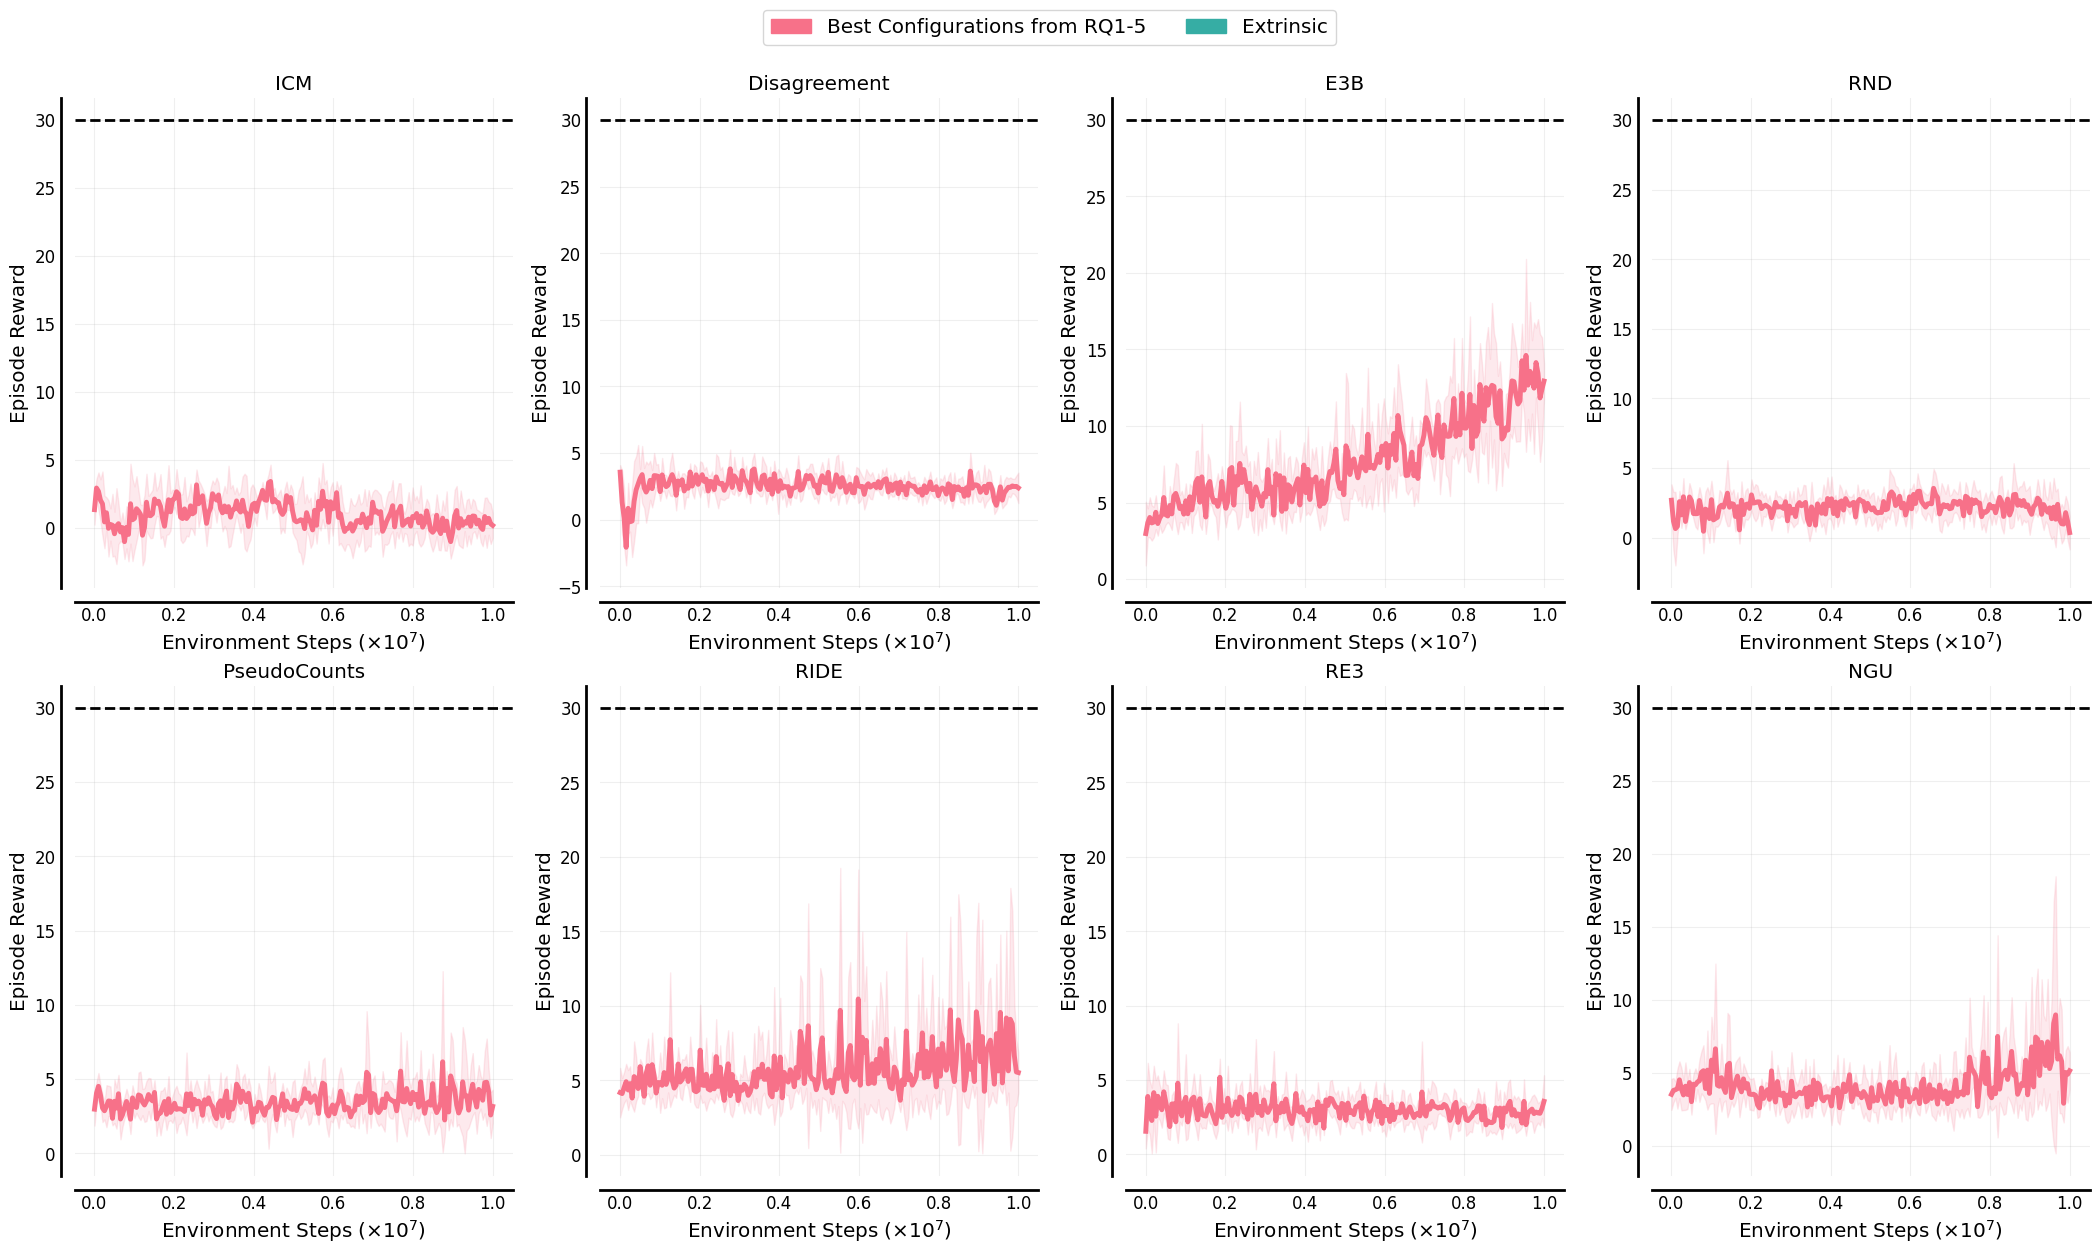

In [4]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU']
candidates = ['default', 'orthogonal']
legends = ['Best Configurations from RQ1-5', 'Extrinsic']
colors = sns.husl_palette(len(candidates))
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(candidates)]
fake_patches.append(mpatches.Patch(color='k', label="Extrinsic"))

fig, axes = plt.subplots(2, 4, figsize=(26, 14))

for subplot_idx, candidate in enumerate(['']):
    root = f"/Users/yuanmingqi/Downloads/nips2024_data/q7_new/"
    num_points = 200
    all_data = {algo: [] for algo in algos}

    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir:
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)['episode_reward']
                data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
                all_data[algo].append(data)

        all_data[algo] = np.array(all_data[algo])
        print(candidate, algo, all_data[algo].shape)

    for algo_idx, algo in enumerate(algos):
        mean, std = np.mean(all_data[algo], axis=0), np.std(all_data[algo], axis=0)
        ax = axes.flatten()[algo_idx]
        x = np.linspace(0, 1.0, num_points)
        if subplot_idx == 0:
            ax.axhline(y=30.0, color='k', linestyle='--', linewidth=2, label="Extrinsic")
        
        ax.plot(x, mean, linewidth=3.5, c=colors[subplot_idx], label=legends[subplot_idx])
        ax.fill_between(x, mean+std, mean-std, alpha=0.15, color=colors[subplot_idx])
        # ax.set_ylim(0, 10)
        ax.set_title(algos[algo_idx], fontsize="x-large")
        ax = _annotate_and_decorate_axis(ax, 
                                        ticklabelsize="large",
                                        xlabel=r"Environment Steps ($\times 10^7$)", 
                                        ylabel="Episode Reward",
                                        xticklabels=np.linspace(0, 1, num_points),
                                        )
        
fig.legend(fake_patches, legends, loc='upper center', 
    fancybox=True, ncol=len(algos), 
    fontsize='x-large',
    bbox_to_anchor=(0.5, 0.95))
fig.savefig('figure_rq7_curves.pdf', bbox_inches='tight', dpi=300)